In [32]:
import cffi
import os
import numpy as np
import pandas as pd
from io import StringIO
from enum import Enum
from Bio import SeqIO
from Bio import Entrez
from pathlib import Path
from modules.auxiliary import DATA_SEQ_DIR
from modules.pytrsomix import TRScalculator, SeqAnalyzer
import matplotlib.pyplot as plt
from multiprocessing import Pool
import glob
import re

In [2]:
def ensure_directory_exists(directory_path): #will be imported
    """
    Ensure that the specified directory exists. If it does not exist, it is created.

    Parameters:
    - directory_path: The path of the directory to check and potentially create.
    """
    if not os.path.exists(directory_path):
        print(f"Directory {directory_path} does not exist! Make sure you move blast files there before you continue!")
        os.makedirs(directory_path)
        print(f"Directory {directory_path} created.")

In [3]:
'''

This works okay but due to the high amount of unique nucleotide database ids takes a lot of time as such
I deemed using the ncbi nucl_taxonomy database to be more viable approach we must attend to this matter
by increasing the size of sequences that we want to study which in turn would probably reduce the number
of unique acessions and make approach down below more viable.

Alternatively we can bundle the cache that
is currently being generated and hope that due to it's large size it will reduce the 
running time of the script below.

OR get priority access from ncbi(unlikely)


import os
import time
import pickle
from Bio import Entrez

ENTREZ_EMAIL = 'mokryziom@gmail.com'
CACHE_FILE = 'organism_cache.pkl'
MAX_RETRY_ATTEMPTS = 3
MAX_RETRY_DELAY = 10  # seconds
BATCH_SIZE = 10

def save_to_cache(data, filename=CACHE_FILE):
    try:
        existing_data = load_cache(filename)
        existing_data.update(data)
        with open(filename, 'wb') as f:
            pickle.dump(existing_data, f)
        print("Cache updated successfully.")
    except Exception as e:
        print(f"Error saving cache: {e}")


def load_cache(filename=CACHE_FILE):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {}

def fetch_organism_names(accessions_batch, organism_to_accessions_cache):
    results = {}
    try:
        for accession in accessions_batch:
            if accession in organism_to_accessions_cache:
                print(f"Accession {accession} found in cache.")
                organism = organism_to_accessions_cache[accession]
                results.setdefault(organism, []).append(accession)
            else:
                for _ in range(MAX_RETRY_ATTEMPTS):
                    try:
                        print(f"Querying NCBI for accession: {accession}")
                        Entrez.email = ENTREZ_EMAIL
                        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
                        record = handle.read()
                        handle.close()

                        organism = extract_organism_name(record)
                        if organism:
                            results.setdefault(organism, []).append(accession)
                            organism_to_accessions_cache[accession] = organism
                        break
                    except Exception as e:
                        print(f"Error occurred for accession {accession}: {e}")
                        time.sleep(2 ** MAX_RETRY_ATTEMPTS if MAX_RETRY_ATTEMPTS < MAX_RETRY_DELAY else MAX_RETRY_DELAY)
    except Exception as e:
        print(f"Error fetching organism names for accessions: {e}")

    # Save cache after processing batch
    save_to_cache(organism_to_accessions_cache)
    return results

def extract_organism_name(record):
    for line in record.split('\n'):
        if line.startswith('  ORGANISM'):
            return line.split('ORGANISM')[1].strip()

def process_folder(folder_path, organism_to_accessions_cache):
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            print(f"Processing file: {filename}")
            blast_file = os.path.join(folder_path, filename)
            process_blast_output(blast_file, organism_to_accessions_cache)
            print(f"File {filename} processed.\n")

def process_blast_output(blast_file, organism_to_accessions_cache):
    print(f"Processing file: {blast_file}")
    accessions = []  # Use a list to store accessions
    with open(blast_file, 'r') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) > 1:
                accession = fields[1]
                accessions.append(accession)  # Add accession to the list

    # Remove duplicates while preserving order
    accessions = list(dict.fromkeys(accessions))
    print("Unique accessions: " + str(len(accessions)))
    
    # Save unique accessions to a text file
    #output_file_path = os.path.splitext(blast_file)[0] + "_unique_accessions.txt"
    #with open(output_file_path, 'w') as f:
        #for accession in accessions:
            #f.write(accession + '\n')

    #print(f"Unique accessions saved to {output_file_path}")

    # Create batches of defined size
    for i in range(0, len(accessions), BATCH_SIZE):
        batch = accessions[i:i+BATCH_SIZE]
        if batch:
            # Use fetch_organism_names to fetch organism names for this batch
            organism_mapping = fetch_organism_names(batch, organism_to_accessions_cache)

            # Save the organism_mapping to cache
            save_to_cache(organism_mapping)

if __name__ == "__main__":
    organism_to_accessions_cache = load_cache()
    folder_path = "/home/hubert/TRS-omix/python/res/processed"
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        process_folder(folder_path, organism_to_accessions_cache)
    else:
        print(f"Invalid folder path: {folder_path}")
'''


'\n\nThis works okay but due to the high amount of unique nucleotide database ids takes a lot of time as such\nI deemed using the ncbi nucl_taxonomy database to be more viable approach we must attend to this matter\nby increasing the size of sequences that we want to study which in turn would probably reduce the number\nof unique acessions and make approach down below more viable.\n\nAlternatively we can bundle the cache that\nis currently being generated and hope that due to it\'s large size it will reduce the \nrunning time of the script below.\n\nOR get priority access from ncbi(unlikely)\n\n\nimport os\nimport time\nimport pickle\nfrom Bio import Entrez\n\nENTREZ_EMAIL = \'mokryziom@gmail.com\'\nCACHE_FILE = \'organism_cache.pkl\'\nMAX_RETRY_ATTEMPTS = 3\nMAX_RETRY_DELAY = 10  # seconds\nBATCH_SIZE = 10\n\ndef save_to_cache(data, filename=CACHE_FILE):\n    try:\n        existing_data = load_cache(filename)\n        existing_data.update(data)\n        with open(filename, \'wb\') as 

In [4]:
def find_directory_by_name(directory_name):
    """
    Searches for directories with a specified name in common locations on the user's computer
    and allows the user to select one if multiple are found.
    
    Parameters:
    - directory_name (str): The name of the directory to search for.
    
    Returns:
    - str: The selected path to the specified directory, or None if not found.
    """
    import os
    
    common_locations = [
        os.path.expanduser('~'),
        os.path.join(os.path.expanduser('~'), 'Documents'),
        os.path.join(os.path.expanduser('~'), 'Desktop')
    ]
    
    found_directories = []
    for location in common_locations:
        for root, dirs, _ in os.walk(location):
            if directory_name in dirs:
                found_directories.append(os.path.join(root, directory_name))
    
    # If no directories were found
    if not found_directories:
        return None
    
    # If only one directory was found, return it
    if len(found_directories) == 1:
        return found_directories[0]
    
    # If multiple directories were found, ask the user to choose one
    print(f"Multiple '{directory_name}' directories found. Please select one:")
    for i, directory in enumerate(found_directories, start=1):
        print(f"{i}. {directory}")
    
    selection = input("Enter the number of the directory you want to use: ")
    try:
        selected_index = int(selection) - 1  # Convert to zero-based index
        if 0 <= selected_index < len(found_directories):
            return found_directories[selected_index]
        else:
            print("Invalid selection. Exiting.")
            return None
    except ValueError:
        print("Invalid input. Please enter a number. Exiting.")
        return None

def filter_and_overwrite_blast_file(file_path):
    """
    Processes a BLAST output file to remove duplicate pairs of sequence ID and accession numbers,
    keeping the first occurrence of each unique pair along with the entire line of data.
    
    This function reads a file specified by `file_path`, identifies the first occurrence of unique 
    sequence ID and accession number pairs, and overwrites the original file with those lines.
    
    Parameters:
    - file_path (str): The path to the BLAST output file to be processed.
    """
    unique_pairs = set()
    lines_to_keep = []

    try:
        with open(file_path, 'r') as file:
            for line in file:
                columns = line.strip().split('\t')
                if len(columns) >= 2:
                    pair = (columns[0], columns[1])
                    if pair not in unique_pairs:
                        unique_pairs.add(pair)
                        lines_to_keep.append(line)
        
        with open(file_path, 'w') as file:
            file.writelines(lines_to_keep)
    except IOError as e:
        print(f"An error occurred while processing {file_path}: {e}")
        
def rename_files_to_txt(directory_path):
    """
    Identifies non-txt files in the specified directory and renames them to have a .txt extension,
    after user confirmation.
    
    Parameters:
    - directory_path (str): The path to the directory where files will be checked and potentially renamed.
    """
    non_txt_files = [f for f in os.listdir(directory_path) if not f.endswith(".txt")]
    
    if non_txt_files:
        print("Found non-txt files:")
        for file in non_txt_files:
            print(file)
        
        user_input = input("Do you want to rename these files to include a .txt extension? (y/n): ")
        if user_input.lower() == 'y':
            for file in non_txt_files:
                original_path = os.path.join(directory_path, file)
                new_path = f"{original_path}.txt"
                try:
                    os.rename(original_path, new_path)
                    print(f"Renamed {file} to {file}.txt")
                except Exception as e:
                    print(f"Failed to rename {file}: {e}")
        else:
            print("No files were renamed.")
    else:
        print("No non-txt files found.")

def process_blast_files_in_directory(directory_path):
    """
    Processes all BLAST output files in a specified directory to remove duplicate pairs,
    keeping the first occurrence of each unique pair along with the entire line of data.
    
    This function searches for all files in `directory_path` ending with '.txt', and for each file,
    it calls `filter_and_overwrite_blast_file` to process and overwrite it with a filtered version
    containing only unique sequence ID and accession number pairs.
    
    Parameters:
    - directory_path (str): The path to the directory containing BLAST output files.
    """
    txt_files = [f for f in os.listdir(directory_path) if f.endswith(".txt")]
    
    if not txt_files:
        print("No .txt files found in the directory. Please check your files and rename them if necessary.")
        sys.exit("Exiting program because no .txt files were found.")
        return
    
    try:
        for filename in txt_files:
            file_path = os.path.join(directory_path, filename)
            filter_and_overwrite_blast_file(file_path)
            print(f"Processed {filename}")
    except Exception as e:
        print(f"An error occurred while processing the directory {directory_path}: {e}")

# Attempt to find the 'blast_output' directory
blast_output_path = find_directory_by_name('blast_output')
rename_files_to_txt(blast)

# If not found, ask the user to provide it
if blast_output_path:
    print(f"Selected directory: {blast_output_path}")
else:
    # If blast_output_path is either None or an empty string, prompt the user for the path.
    print("No 'blast_output' directory selected or found.")
    blast_output_path = input("Please provide the path to the 'taxonomy' directory: ")


process_blast_files_in_directory(blast_output_path)


Multiple 'blast_output' directories found. Please select one:
1. /home/hubert/TRS-omix/python/klebsiella_results_L100_R100_c1.0/blast_output
2. /home/hubert/TRS-omix/python/klebsiella_results_L200_R200_c0.75/blast_output
3. /home/hubert/TRS-omix/python/klebsiella_results_L200_R200_c1.0/blast_output
4. /home/hubert/TRS-omix/python/klebsiella_results_L100_R100_c0.75/blast_output
5. /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c1.0/blast_output
6. /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c0.75/blast_output
Enter the number of the directory you want to use: 6
Found non-txt files:
cluster_sequences_combined_unique_blastn_out
filtered_sequences_combined_unique_blastn_out
Do you want to rename these files to include a .txt extension? (y/n): y
Renamed cluster_sequences_combined_unique_blastn_out to cluster_sequences_combined_unique_blastn_out.txt
Renamed filtered_sequences_combined_unique_blastn_out to filtered_sequences_combined_unique_blastn_out.txt
Selected directo

'/home/hubert/TRS-omix/python/klebsiella_results/blast_output'

In [5]:
def collect_accessions_from_blast_files(folder_path):
    """Collects unique accessions from BLAST files in the specified folder."""
    unique_accessions = set()
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Adjust this condition based on your file naming convention
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    columns = line.strip().split('\t')
                    if len(columns) > 1:  # Assuming at least two columns are present
                        accession = columns[1]
                        unique_accessions.add(accession)
    return unique_accessions

def filter_taxonomy_file(taxonomy_file, accessions, chunksize=50000):
    """Filters the taxonomy file in chunks, keeping rows matching the accessions from BLAST files."""
    filtered_rows = []
    cols_to_use = [1, 2]  # Adjust these indices based on your file structure (0-indexed)
    for chunk in pd.read_csv(taxonomy_file, sep='\t', usecols=cols_to_use, header=None, chunksize=chunksize):
        # Assuming the accession numbers are in the first column of the chunk, adjust if necessary
        filtered_chunk = chunk[chunk.iloc[:, 0].isin(accessions)]
        filtered_rows.append(filtered_chunk)
    return pd.concat(filtered_rows, ignore_index=True)

# Example usage
taxonomy_path = find_directory_by_name('taxonomy')
if taxonomy_path:
    print(f"Selected directory: {taxonomy_path}")
else:
    # If taxonomy_path is either None or an empty string, prompt the user for the path.
    print("No 'taxonomy' directory selected or found.")
    taxonomy_path = input("Please provide the path to the 'taxonomy' directory: ")


taxonomy_file = f"{taxonomy_path}/nucl_gb.accession2taxid"

#Collect accessions from BLAST files
accessions = collect_accessions_from_blast_files(blast_output_path)

#Filter the taxonomy file using collected accessions
tax_df = filter_taxonomy_file(taxonomy_file, accessions)

# At this point, `tax_df` holds the filtered lines from the taxonomy file

#Save to df to .csv in the same folder taxonomy is in
output_file = os.path.join(blast_output_path, "taxonomy_filtered.csv")
tax_df.to_csv(output_file, index=False)
print(f"tax_df saved to {output_file}")

Multiple 'taxonomy' directories found. Please select one:
1. /home/hubert/TRS-omix/python/taxonomy
2. /home/hubert/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/q2_types/feature_data/tests/data/taxonomy
3. /home/hubert/miniconda3/pkgs/q2-types-2023.2.0-py38_0/lib/python3.8/site-packages/q2_types/feature_data/tests/data/taxonomy
4. /home/hubert/Krona/KronaTools/taxonomy
Enter the number of the directory you want to use: 1
Selected directory: /home/hubert/TRS-omix/python/taxonomy
tax_df saved to /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c0.75/blast_output/taxonomy_filtered.csv


In [6]:
taxid_accessions_dict = {}
for index, row in tax_df.iterrows():
    accession_column = tax_df.columns[0]  # Extract accession column dynamically
    taxid_column = tax_df.columns[1]  # Extract taxid column dynamically
    
    accession = row[accession_column]
    taxid = row[taxid_column]
    
    if taxid in taxid_accessions_dict:
        taxid_accessions_dict[taxid].append(accession)
    else:
        taxid_accessions_dict[taxid] = [accession]


In [7]:
# Ensure the directory for modified files exists
modified_blast_path = os.path.join(blast_output_path, "modified_blast")
ensure_directory_exists(modified_blast_path)  # Ensure this function creates the directory if it doesn't exist

# Optimized: Invert the taxid_accessions_dict for efficient lookup
# This step assumes each accession maps to exactly one taxid
accession_to_taxid = {accession: taxid for taxid, accessions in taxid_accessions_dict.items() for accession in accessions}

def map_accession_to_taxid(accession):
    """Map accession to TaxID using the optimized lookup dictionary."""
    return accession_to_taxid.get(accession, '')  # Return empty string if accession not found

# Iterate over files in the input directory
for filename in os.listdir(blast_output_path):
    if filename.endswith(".txt"):
        input_file_path = os.path.join(blast_output_path, filename)
        
        # Read the file into a DataFrame
        df = pd.read_csv(input_file_path, sep='\t', header=None)  # No column names specified
        
        # Map accessions to TaxIDs and add them as a new column after the last existing column
        df[df.shape[1]] = df[1].map(map_accession_to_taxid)  # Assuming column 1 contains the accessions
        
        # Construct output file path
        modified_file_path = os.path.join(modified_blast_path, f"taxids_{filename}")
        
        # Save the modified DataFrame to a new file in the output directory
        df.to_csv(modified_file_path, sep='\t', index=False, header=False)


Directory /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c0.75/blast_output/modified_blast created.


In [8]:
''' make this automatic for example by using ORGANISM column from 
combined_results might need to query the db twice once for species and then using species to query taxonomy for taxids '''
species_info = {
    "Klebsiella pneumoniae subsp. pneumoniae": "72407",
    "Klebsiella quasivariicola": "2026240",
    "Klebsiella quasipneumoniae subsp. quasipneumoniae": "1667327",
    "Klebsiella quasipneumoniae subsp. similipneumoniae": "1463164",
    "Klebsiella africana": "2489010",
    "Klebsiella variicola subsp. variicola": "2590157",
    "Klebsiella variicola subsp. tropica": "2489014",
    "Klebsiella pneumoniae": "573"
}

{'Klebsiella pneumoniae subsp. pneumoniae': 72407,
 'Klebsiella quasivariicola': 2026240,
 'Klebsiella quasipneumoniae subsp. quasipneumoniae': 1667327,
 'Klebsiella quasipneumoniae subsp. similipneumoniae': 1463164,
 'Klebsiella africana': 2489010,
 'Klebsiella variicola subsp. variicola': 2590157,
 'Klebsiella variicola subsp. tropica': 2489014,
 'Klebsiella pneumoniae': 573}

In [9]:
def construct_dictionary_from_files_optimized(directory):
    data_dictionary = {}

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            # Determine the number of columns to optimize reading
            with open(filepath, 'r') as f:
                first_line = f.readline()
                num_columns = len(first_line.split('\t'))
            
            # Read only the necessary columns (first and last)
            df = pd.read_csv(filepath, sep='\t', header=None, usecols=[0, num_columns-1])
            
            # Group by the first column and convert the last column values to sets
            grouped = df.groupby(0)[num_columns-1].apply(set).to_dict()
            
            # Merge the current file's dictionary with the main dictionary
            for key, value_set in grouped.items():
                if key in data_dictionary:
                    data_dictionary[key].update(value_set)
                else:
                    data_dictionary[key] = value_set

    return data_dictionary

result_dict = construct_dictionary_from_files_optimized(modified_blast_path)
result_dict

{'Klebsiella_africana_L10_17397': {573.0,
  574.0,
  72407.0,
  244366.0,
  1365186.0,
  2267618.0,
  2986524.0},
 'Klebsiella_africana_L10_17409': {573.0, 2489010.0},
 'Klebsiella_africana_L10_17419': {2489010.0},
 'Klebsiella_africana_L10_17527': {1972757.0, 2489010.0},
 'Klebsiella_africana_L10_17767': {244366.0,
  1463165.0,
  1972757.0,
  2026240.0,
  2489010.0},
 'Klebsiella_africana_L10_17969': {573.0,
  244366.0,
  640131.0,
  2267618.0,
  2489010.0,
  2489014.0,
  2590157.0},
 'Klebsiella_africana_L10_18057': {2489010.0},
 'Klebsiella_africana_L10_18061': {2489010.0},
 'Klebsiella_africana_L10_18147': {2489010.0},
 'Klebsiella_africana_L10_18231': {1972757.0, 2026240.0, 2489010.0},
 'Klebsiella_africana_L10_18271': {545.0,
  546.0,
  548.0,
  562.0,
  564.0,
  573.0,
  577.0,
  595.0,
  611.0,
  623.0,
  624.0,
  28901.0,
  41520.0,
  54736.0,
  57046.0,
  58095.0,
  58712.0,
  59201.0,
  72407.0,
  83334.0,
  90105.0,
  90370.0,
  90371.0,
  149539.0,
  158877.0,
  184912.0,


In [13]:
with open('my_long_dict.txt', 'w') as f:
    for key, value_set in result_dict.items():
        # Convert the set to a sorted list for consistent ordering, then to string
        value_str = str(sorted(list(value_set)))
        f.write(f"{key}: {value_str}\n")

In [14]:
# Convert values in the dictionary to int
species_info = {key: int(value) for key, value in species_info.items()}

# Filtered dictionary to store keys from result_dict that contain only values listed in species_info
filtered_result_dict = {}

# Iterate through the keys and values of result_dict
for key, value in result_dict.items():
    # Check if all values in the set are present in species_info values
    if all(val in species_info.values() for val in value):
        # If yes, add the key-value pair to the filtered dictionary
        filtered_result_dict[key] = value

# New dictionary to store keys from filtered_result_dict and matching keys from species_info
final_dict = {}

{'Klebsiella_africana_L10_17409': {573.0, 2489010.0},
 'Klebsiella_africana_L10_17419': {2489010.0},
 'Klebsiella_africana_L10_18057': {2489010.0},
 'Klebsiella_africana_L10_18061': {2489010.0},
 'Klebsiella_africana_L10_18147': {2489010.0},
 'Klebsiella_africana_L10_18339': {2489010.0},
 'Klebsiella_africana_L10_18355': {2489010.0},
 'Klebsiella_africana_L10_18497': {2489010.0},
 'Klebsiella_africana_L10_18745': {2489010.0},
 'Klebsiella_africana_L10_18753': {573.0, 72407.0, 2489010.0},
 'Klebsiella_africana_L10_18935': {2489010.0},
 'Klebsiella_africana_L10_19027': {2489010.0},
 'Klebsiella_africana_L10_19153': {2489010.0},
 'Klebsiella_africana_L10_19171': {2489010.0},
 'Klebsiella_africana_L10_19353': {2489010.0},
 'Klebsiella_africana_L10_19585': {2489010.0},
 'Klebsiella_africana_L10_19603': {2489010.0},
 'Klebsiella_africana_L10_19657': {2489010.0},
 'Klebsiella_africana_L10_19823': {2489010.0},
 'Klebsiella_africana_L10_20037': {2489010.0},
 'Klebsiella_africana_L10_20467': {24

In [10]:
# Iterate through the keys and values of filtered_result_dict
for key, value in filtered_result_dict.items():
    # Find the matching keys in species_info for each value
    matching_keys = [species_key for species_key, species_value in species_info.items() if species_value in value]
    # Add the key-value pair to the final dictionary
    final_dict[key] = matching_keys

def remove_keys_with_multiple_values(final_dict):
    # Create a new dictionary to store keys with single values
    filtered_dict = {}
    
    # Iterate over the items in final_dict
    for key, value in final_dict.items():
        # Check if the value associated with the key is a list
        if isinstance(value, list) and len(value) == 1:
            # If the value is a list with only one element, keep the key-value pair
            filtered_dict[key] = value[0]
        elif not isinstance(value, list):
            # If the value is not a list, keep the key-value pair
            filtered_dict[key] = value
            
    return filtered_dict

# Example usage:
filtered_final_dict = remove_keys_with_multiple_values(final_dict)
filtered_final_dict

{'Klebsiella_africana_L10_17419': 'Klebsiella africana',
 'Klebsiella_africana_L10_18057': 'Klebsiella africana',
 'Klebsiella_africana_L10_18061': 'Klebsiella africana',
 'Klebsiella_africana_L10_18147': 'Klebsiella africana',
 'Klebsiella_africana_L10_18339': 'Klebsiella africana',
 'Klebsiella_africana_L10_18355': 'Klebsiella africana',
 'Klebsiella_africana_L10_18497': 'Klebsiella africana',
 'Klebsiella_africana_L10_18745': 'Klebsiella africana',
 'Klebsiella_africana_L10_18935': 'Klebsiella africana',
 'Klebsiella_africana_L10_19027': 'Klebsiella africana',
 'Klebsiella_africana_L10_19153': 'Klebsiella africana',
 'Klebsiella_africana_L10_19171': 'Klebsiella africana',
 'Klebsiella_africana_L10_19353': 'Klebsiella africana',
 'Klebsiella_africana_L10_19585': 'Klebsiella africana',
 'Klebsiella_africana_L10_19603': 'Klebsiella africana',
 'Klebsiella_africana_L10_19657': 'Klebsiella africana',
 'Klebsiella_africana_L10_19823': 'Klebsiella africana',
 'Klebsiella_africana_L10_20037

In [30]:
def process_files_with_filter(directory, filtered_dict):
    output_directory = os.path.join(directory, "final_output")
    os.makedirs(output_directory, exist_ok=True)  # Ensure the output directory exists

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            input_filepath = os.path.join(directory, filename)
            output_filepath = os.path.join(output_directory, f"final_{filename}")
            
            df = pd.read_csv(input_filepath, sep='\t', header=None)

            # Create a boolean mask for rows where the first column matches keys in filtered_dict
            mask = df[0].isin(filtered_dict.keys())

            # Instead of creating a filtered DataFrame, directly modify the last column of the original DataFrame using .loc
            df.loc[mask, df.columns[-1]] = df.loc[mask, 0].map(filtered_dict)

            # Now, filter the DataFrame to keep only the rows that match the mask
            filtered_df = df[mask]

            filtered_df.to_csv(output_filepath, sep='\t', index=False, header=False)
            print(f"Final output saved at {output_filepath}")


# Example usage
process_files_with_filter(modified_blast_path, filtered_final_dict)


Final output saved at /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c0.75/blast_output/modified_blast/final_output/final_taxids_cluster_sequences_combined_unique_blastn_out.txt
Final output saved at /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c0.75/blast_output/modified_blast/final_output/final_taxids_filtered_sequences_combined_unique_blastn_out.txt


In [28]:
#Filter initial fasta to keep only those that were unique

filtered_sequences_directory = find_directory_by_name('filtered_sequences')
final_output = find_directory_by_name('final_output')
output_directory = os.path.join(final_output,"final_fasta")
os.makedirs(output_directory, exist_ok=True)


Multiple 'filtered_sequences' directories found. Please select one:
1. /home/hubert/TRS-omix/python/klebsiella_results_L100_R100_c1.0/filtered_sequences
2. /home/hubert/TRS-omix/python/klebsiella_results_L200_R200_c0.75/filtered_sequences
3. /home/hubert/TRS-omix/python/klebsiella_results_L200_R200_c1.0/filtered_sequences
4. /home/hubert/TRS-omix/python/klebsiella_results_L100_R100_c0.75/filtered_sequences
5. /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c1.0/filtered_sequences
6. /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c0.75/filtered_sequences
Enter the number of the directory you want to use: 6
Multiple 'final_output' directories found. Please select one:
1. /home/hubert/TRS-omix/python/klebsiella_results_L100_R100_c1.0/blast_output/modified_blast/final_output
2. /home/hubert/TRS-omix/python/klebsiella_results_L200_R200_c1.0/blast_output/modified_blast/final_output
3. /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c1.0/blast_output/modified_blast/fi

In [34]:
txt_files = glob.glob(os.path.join(final_output, 'final_taxids_*_unique_blastn_out.txt'))

In [35]:
for txt_file in txt_files:
    # Extract file_name
    base_name = os.path.basename(txt_file)
    file_name = base_name.replace('final_taxids_', '').replace('_unique_blastn_out.txt', '')
    
    # Read seqIDs from txt file
    with open(txt_file, 'r') as f:
        seqIDs = [line.split()[0] for line in f.readlines()]
    
    # Match seqIDs Against .fasta Files
    fasta_file = glob.glob(os.path.join(filtered_sequences_directory, f'*{file_name}*.fasta'))
    if fasta_file:
        fasta_file = fasta_file[0]  # Assuming only one match
        with open(fasta_file, 'r') as f:
            fasta_lines = f.readlines()
        
        output_file_path = os.path.join(output_directory, f'matched_sequences_{file_name}.fasta')
        with open(output_file_path, 'w') as output_file:
            write_sequence = False
            for line in fasta_lines:
                if line.startswith('>'):
                    seqID = line[1:].strip()
                    write_sequence = seqID in seqIDs
                if write_sequence:
                    output_file.write(line)

        print(f"Matched sequences for {file_name} have been written to {output_file_path}")

'''Kolejne zostaw tylko pary'''

Matched sequences for filtered_sequences_combined have been written to /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c0.75/blast_output/modified_blast/final_output/final_fasta/matched_sequences_filtered_sequences_combined.fasta
Matched sequences for cluster_sequences_combined have been written to /home/hubert/TRS-omix/python/klebsiella_results_L50_R50_c0.75/blast_output/modified_blast/final_output/final_fasta/matched_sequences_cluster_sequences_combined.fasta


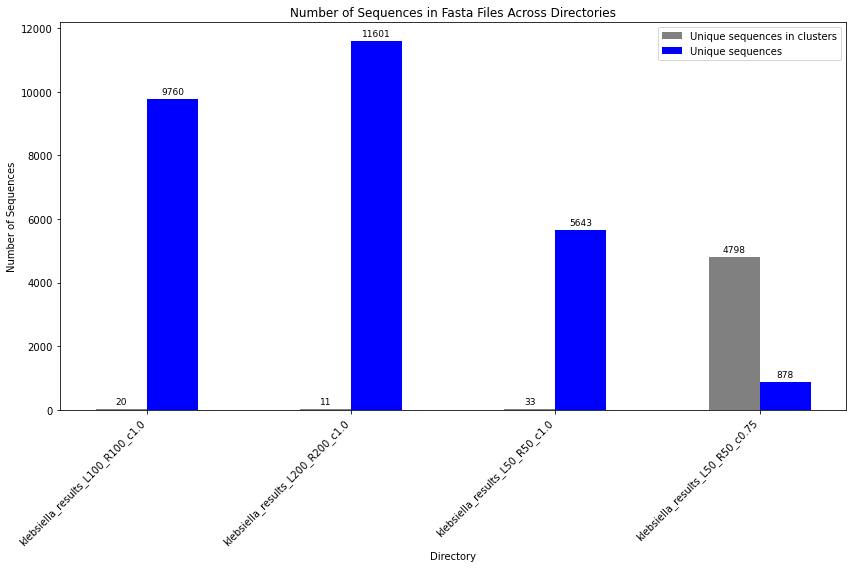

In [36]:
'''def count_sequences_in_fasta(file_path):
    """Count the number of sequences in a fasta file."""
    with open(file_path, 'r') as file:
        return sum(1 for line in file if line.startswith('>'))

def find_directories(target_dir_name):
    """Find directories with a specific name in the current working directory tree, and extract relevant parent directory names."""
    pattern = re.compile(r'.*_results_L\d+_R\d+_c[\d\.]+')
    for dirpath, dirnames, files in os.walk(os.getcwd()):
        if os.path.basename(dirpath) == target_dir_name:
            match = pattern.search(dirpath)
            if match:
                parent_name = match.group()
                yield dirpath, os.path.basename(os.path.normpath(parent_name))

def check_fasta_file_counts(target_dirs):
    """Check for directories with more than two fasta files and print a warning."""
    for dir_path in target_dirs:
        fasta_files = glob.glob(os.path.join(dir_path, '*.fasta'))
        if len(fasta_files) > 2:
            print(f"Warning: {dir_path} contains more than two fasta files.")

target_dir_name = 'final_fasta'
sequence_counts = {}
directories = list(find_directories(target_dir_name))

check_fasta_file_counts([dir_path for dir_path, _ in directories])

for target_dir, parent_name in directories:
    fasta_files = glob.glob(os.path.join(target_dir, '*.fasta'))
    for f in fasta_files:
        file_base_name = os.path.basename(f)
        sequence_counts.setdefault(parent_name, {})[file_base_name] = count_sequences_in_fasta(f)

file_aliases = {
    'matched_sequences_cluster_sequences_combined.fasta': 'Unique sequences in clusters'
}

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.25
index = np.arange(len(sequence_counts))

for i, (parent_name, counts) in enumerate(sequence_counts.items()):
    for j, (file_name, count) in enumerate(counts.items()):
        label = file_aliases.get(file_name, "Unique sequences")
        bar = ax.bar(index[i] + j*bar_width, count, bar_width, label=label if i == 0 else "", color='grey' if file_name in file_aliases else 'blue')
        # Adding annotations for each bar
        ax.annotate(f'{count}',
                    xy=(index[i] + j*bar_width, count),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, color='black')

ax.set_xlabel('Directory')
ax.set_ylabel('Number of Sequences')
ax.set_title('Number of Sequences in Fasta Files Across Directories')
ax.set_xticks(index + bar_width / 2 * (len(counts) - 1))
ax.set_xticklabels(sequence_counts.keys(), rotation=45, ha="right")
if len(sequence_counts.keys()) > 1:
    ax.legend()

plt.tight_layout()
plt.show()
'''

In [37]:
'''# Lets try to sort out the negative sorting using blast
find_directory_by_name
ensure_directory_exists
filter_and_overwrite_blast_file
rename_files_to_txt

blast_output_path = find_directory_by_name('blast_output')
rename_files_to_txt(blast_output_path)
filter_and_overwrite_blast_filer(blast_output_path) 
'''
'''
We get a list of sequence ids that we are not intrested in so all we have to do is exclude them from initial 
.fasta file but here is the problem now we have a list of sequences that match to 
any number of acessions of any number of KBP species and no way to identify them which would 
require us to run blast again this time on those sequences we kept
'''

<function __main__.ensure_directory_exists(directory_path)>